# Overview 
- Permutation Importance クラスを作成する

# Import everything I need :)

In [56]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import seaborn as sns

# Preparation

## set

In [51]:
pd.set_option('display.max_columns', 100)

<br>

## datasets

In [52]:
boston = load_boston()
df_boston = pd.DataFrame(boston.data, columns=boston.feature_names)
target = boston.target

df_boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


<br>

## all function

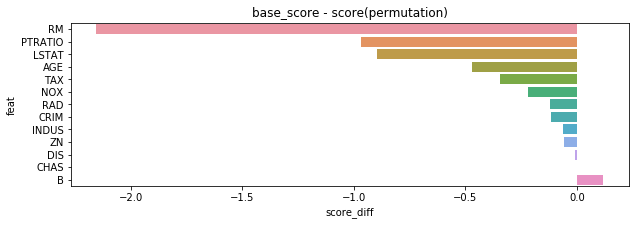

In [113]:
class permutation_importance():
    def __init__(self, X_valid, y_valid, model, metric):
        self.is_computed = False
        self.n_feat = len(X_valid.columns)
        self.base_score = metric(y_valid, model.predict(X_valid))
        self.df_result = pd.DataFrame({'feat': X_valid.columns, 
                                       'score': np.zeros(self.n_feat),
                                       'score_diff': np.zeros(self.n_feat)})
    
    def compute(self):
        for i, col in enumerate(X_valid.columns):
            df_perm = X_valid.copy()
            df_perm[col] = np.random.permutation(df_perm[col])
            y_valid_pred = model.predict(df_perm)
            score = metric(y_valid, y_valid_pred)
            self.df_result['score'][df_result['feat']==col] = score
            self.df_result['score_diff'][df_result['feat']==col] = base_score - score
        self.is_computed = True
        
    
    def get_negative_feature(self):
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        
    def get_positive_feature(self):
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        print('positive')
    
    def show_permutation_importance(self):
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        plt.figure(figsize=(10, int(0.25*self.n_feat)))
        sns.barplot(x="score_diff", y="feat", data=self.df_result.sort_values(by="score_diff", ascending=True))
        plt.title('base_score - score(permutation)')
        print('')
        
        
    
c = permutation_importance(X_valid, y_valid, model, metric)
c.compute()
c.get_negative_feature()
c.show_permutation_importance()

# Permutation Importance

In [60]:
X = df_boston
y = target
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=42)

In [73]:
model = RandomForestRegressor(n_estimators=1, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [75]:
metric = mean_absolute_error
X_valid = X_valid
y_valid = y_valid
model = model

base_score = metric(y_valid, model.predict(X_valid))

df_result = pd.DataFrame({'feat': X_valid.columns, 
                          'score': np.zeros(len(X_valid.columns)),
                          'score_diff': np.zeros(len(X_valid.columns))})
# scores = []
for i, col in enumerate(X_valid.columns):
    df_perm = X_valid.copy()
    df_perm[col] = np.random.permutation(df_perm[col])
    y_valid_pred = model.predict(df_perm)
    score = metric(y_valid, y_valid_pred)
    df_result['score'][df_result['feat']==col] = score
    df_result['score_diff'][df_result['feat']==col] = base_score - score

In [76]:
df_result

,feat,score,score_diff
0,CRIM,3.694611,-0.168862
1,ZN,3.550299,-0.024551
2,INDUS,3.599401,-0.073653
3,CHAS,3.525749,0.000000
4,NOX,3.798802,-0.273054
5,RM,5.598802,-2.073054
6,AGE,3.884431,-0.358683
7,DIS,3.515569,0.010180
8,RAD,3.627545,-0.101796
9,TAX,3.882036,-0.356287


Text(0.5, 1.0, 'base_score - score(permutation)')

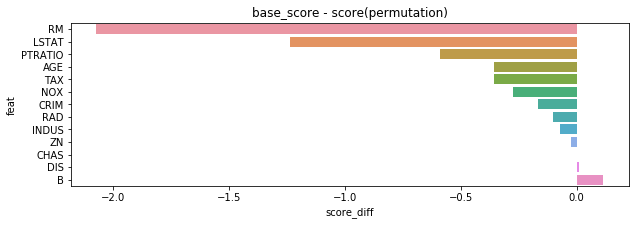

In [96]:
n_feat = len(df_result)
plt.figure(figsize=(10, int(0.25*n_feat)))
sns.barplot(x="score_diff", y="feat", data=df_result.sort_values(by="score_diff", ascending=True))
plt.title('base_score - score(permutation)')

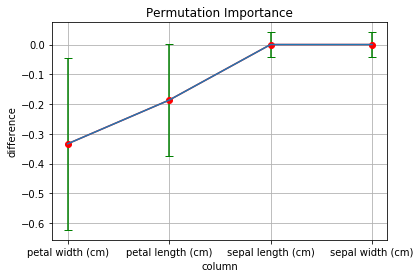

In [8]:
from collections import defaultdict

import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from matplotlib import pyplot as plt


def permuted(df):
    """特定のカラムをシャッフルしたデータフレームを返す"""
    for column_name in df.columns:
        permuted_df = df.copy()
        permuted_df[column_name] = np.random.permutation(permuted_df[column_name])
        yield column_name, permuted_df


def pimp(clf, X, y, cv=None, eval_func=accuracy_score):
    """PIMP (Permutation IMPortance) を計算する"""
    base_scores = []
    permuted_scores = defaultdict(list)

    if cv is None:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for train_index, test_index in cv.split(X, y):
        # 学習用データと検証用データに分割する
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_test, y_test = X.iloc[test_index], y.iloc[test_index]

        # 学習用データでモデルを学習する
        clf.fit(X_train, y_train)

        # まずは何もシャッフルしていないときのスコアを計算する
        y_pred_base = clf.predict(X_test)
        base_score = eval_func(y_test, y_pred_base)
        base_scores.append(base_score)

        # 特定のカラムをシャッフルした状態で推論したときのスコアを計算する
        permuted_X_test_gen = permuted(X_test)
        for column_name, permuted_X_test in permuted_X_test_gen:
            y_pred_permuted = clf.predict(permuted_X_test)
            permuted_score = eval_func(y_test, y_pred_permuted)
            permuted_scores[column_name].append(permuted_score)

    # 基本のスコアとシャッフルしたときのスコアを返す
    np_base_score = np.array(base_scores)
    dict_permuted_score = {name: np.array(scores) for name, scores in permuted_scores.items()}
    return np_base_score, dict_permuted_score


def score_difference_statistics(base, permuted):
    """シャッフルしたときのスコアに関する統計量 (平均・標準偏差) を返す"""
    mean_base_score = base.mean()
    for column_name, scores in permuted.items():
        score_differences = scores - mean_base_score
        yield column_name, score_differences.mean(), score_differences.std()


def main():
    # Iris データセットを読み込む
    dataset = datasets.load_iris()
    X = pd.DataFrame(dataset.data, columns=dataset.feature_names)
    y = pd.Series(dataset.target)

    # 計測に使うモデルを用意する
    clf = RandomForestClassifier(n_estimators=100)

    # Permutation Importance を計測する
    base_score, permuted_scores = pimp(clf, X, y)

    # 計測結果から統計量を計算する
    diff_stats = list(score_difference_statistics(base_score, permuted_scores))

    # カラム名、ベーススコアとの差、95% 信頼区間を取り出す
    sorted_diff_stats = sorted(diff_stats, key=lambda x: x[1])
    column_names = [name for name, _, _ in sorted_diff_stats]
    diff_means = [diff_mean for _, diff_mean, _ in sorted_diff_stats]
    diff_stds_95 = [diff_std * 1.96 for _, _, diff_std in sorted_diff_stats]

    # グラフにプロットする
    plt.plot(column_names, diff_means, marker='o', color='r')
    plt.errorbar(column_names, diff_means, yerr=diff_stds_95, ecolor='g', capsize=4)

    plt.title('Permutation Importance')
    plt.grid()
    plt.xlabel('column')
    plt.ylabel('difference')
    plt.show()


if __name__ == '__main__':
    main()